In [1]:
%%bash
# Do not change or modify this file
# Need to install pyspark
# if pyspark is already installed, will print a message indicating pyspark already isntalled
pip install pyspark

# Download the data files from github
# If the data file does not exist in the colab environment
if [[ ! -f ./finaldf.csv ]]; then 
      wget https://raw.githubusercontent.com/ssadagop97/IST718-Fall2020/main/finaldf.csv
   # download the data file from github and save it in this colab environment instance
fi
ls finaldf.csv

finaldf.csv


In [2]:
import cufflinks as cf
cf.go_offline()
%matplotlib inline
from plotly import tools
from plotly.offline import init_notebook_mode, iplot
init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.figure_factory as ff
import plotly.offline as offline
# Random for well, random stuff
import random
# operator for sorting dictionaries
import operator
# For ignoring warnings
import warnings
warnings.filterwarnings('ignore')


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
from plotly.offline  import download_plotlyjs,init_notebook_mode,plot, iplot

In [4]:
!pip install pyspark

In [5]:
from pyspark.sql import SparkSession
from pyspark.sql import SQLContext
from pyspark.sql.functions import lower, col
spark = SparkSession .builder.master("local[*]").config("spark.memory.fraction", 0.8) .config("spark.executor.memory", "12g").config("spark.driver.memory", "12g").config("spark.memory.offHeap.enabled",'true').config("spark.memory.offHeap.size","12g").getOrCreate()
sc = spark.sparkContext
sqlContext = SQLContext(sc)
df = spark.read.format("csv").option("header", "true").load("finaldf.csv")
print(df.show())
from pyspark.sql.types import DoubleType
from pyspark.sql.types import DateType
#df = df.withColumn("num_tracks_in_album", df["Number of tracks"].cast(DoubleType()))
df= df.withColumn("num_tracks_in_album", df["num_tracks_in_album"].cast(DoubleType()))
df= df.withColumn("year_of_release", df["year_of_release"].cast(DateType()))
df= df.withColumn("num_listens_per_album", df["num_listens_per_album"].cast(DoubleType()))
df= df.withColumn("track_favorites", df["track_favorites"].cast(DoubleType()))
df= df.withColumn("album_favourites", df["album_favourites"].cast(DoubleType()))
df= df.withColumn("duration", df["duration"].cast(DoubleType()))
df= df.withColumn("interest", df["interest"].cast(DoubleType()))
df= df.withColumn("num_listens_per_song", df["num_listens_per_song"].cast(DoubleType()))
df= df.withColumn("chroma_cens", df["chroma_cens"].cast(DoubleType()))
df= df.withColumn("chroma_cqt", df["chroma_cqt"].cast(DoubleType()))
df= df.withColumn("chroma_stft", df["chroma_stft"].cast(DoubleType()))
df= df.withColumn("mfcc", df["mfcc"].cast(DoubleType()))
df= df.withColumn("rmse", df["rmse"].cast(DoubleType()))
df= df.withColumn("spectral_centroid", df["spectral_centroid"].cast(DoubleType()))
df= df.withColumn("spectral_bandwidth", df["spectral_bandwidth"].cast(DoubleType()))
df= df.withColumn("spectral_contrast", df["spectral_contrast"].cast(DoubleType()))
df= df.withColumn("spectral_rolloff", df["spectral_rolloff"].cast(DoubleType()))
df= df.withColumn("tonnetz", df["tonnetz"].cast(DoubleType()))
df= df.withColumn("zcr", df["zcr"].cast(DoubleType()))
features = list(df.columns)
features.remove('_c0')
features.remove('Album Title')
features.remove('Album_ID')
features.remove('Artist_ID')
features.remove('tags')
features.remove('composer')
features.remove('genre_top')
features.remove('title')
features.remove('associated_labels')
features.remove('type')
df = df.select(features)

+-----+--------+--------------------+--------+---------+--------------------+-------------+--------------------+--------------------+--------+--------------------+---------+-------------+-------------------+---------------+---------------------+---------------+----------------+--------+--------+--------------------+-----------+----------+-----------+------+-----+-----------------+------------------+-----------------+----------------+---------+------+
|  _c0|track_id|         Album Title|Album_ID|Artist_ID|               title|         type|   associated_labels|                tags|composer|          top_genres|genre_top|language_code|num_tracks_in_album|year_of_release|num_listens_per_album|track_favorites|album_favourites|duration|interest|num_listens_per_song|chroma_cens|chroma_cqt|chroma_stft|  mfcc| rmse|spectral_centroid|spectral_bandwidth|spectral_contrast|spectral_rolloff|  tonnetz|   zcr|
+-----+--------+--------------------+--------+---------+--------------------+-------------

In [6]:
df.select(features).toPandas()['top_genres'].value_counts() #Sampled  for the top most generes. Randomly picked up approximately 5000 rows per genre for our model
#The junk values are due to excel transitions - we were unable to identify the reason

Hip-Hop/Pop                                                                10649
Electronic/Rock                                                            10061
Classical/Folk/Jazz/Blues                                                  10061
['ariel pinks haunted graffiti']                                               4
['nathan eckel']                                                               2
['sagan']                                                                      1
Beethoven                                                                      1
['intrahealth international']                                                  1
['dubstep', 'trip-hop', 'trap', 'electronica', 'downtempo', 'nihilore']        1
['jonathan biss']                                                              1
Name: top_genres, dtype: int64

VARAIBLE MANIPULATIONS AND Y-VAR SAMPLING

In [7]:
#Clearing up the Junk Genres
from pyspark.sql import functions as fn
from pyspark.sql.functions import col
top_gernes=['Classical/Folk/Jazz/Blues' ,
'Electronic/Rock' ,
'Hip-Hop/Pop'  
]
df = df.withColumn("top_genres",fn.when(col("top_genres").isin(top_gernes), col("top_genres")).otherwise('Hip-Hop/Pop'))

In [8]:
df.select(features).toPandas()['top_genres'].value_counts()

Hip-Hop/Pop                  10664
Electronic/Rock              10061
Classical/Folk/Jazz/Blues    10061
Name: top_genres, dtype: int64

In [9]:
# Cat coding all the categorical columns 
objecttypes =['language_code','year_of_release']
columnList = [item[0] for item in df.dtypes if item[1].startswith('string')]
#cat_columns = df.select(columnList).columns
dontchange = ['top_gernes']
use_cols = [col for col in df.columns if col not in dontchange]

In [10]:
newDF=df.select(use_cols).fillna(0)

In [11]:
features=list(newDF.columns)

In [12]:
def correlation(df):
        import numpy as np
        columnList = [item[0] for item in df.dtypes if item[1].startswith('double')]
        corr_matrix = df.select(columnList).toPandas().corr().abs()
        upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))
        for column in upper.columns:
            if any(upper[column] > 0.70):
                    df.drop(column)

        return(df)

In [13]:
tracks_reduced=[]
tracks_reduced= correlation(newDF)


In [14]:
tracks_reduced.toPandas().shape

(30786, 22)

In [15]:
tracks_reduced=tracks_reduced.replace([np.inf], np.nan)

In [16]:
tracks_reduced.toPandas().top_genres.value_counts()

Hip-Hop/Pop                  10664
Electronic/Rock              10061
Classical/Folk/Jazz/Blues    10061
Name: top_genres, dtype: int64

In [17]:
features = list(tracks_reduced.columns)
print(features)


['track_id', 'top_genres', 'language_code', 'num_tracks_in_album', 'year_of_release', 'num_listens_per_album', 'track_favorites', 'album_favourites', 'duration', 'interest', 'num_listens_per_song', 'chroma_cens', 'chroma_cqt', 'chroma_stft', 'mfcc', 'rmse', 'spectral_centroid', 'spectral_bandwidth', 'spectral_contrast', 'spectral_rolloff', 'tonnetz', 'zcr']


In [18]:
tracks_reduced=tracks_reduced.drop_duplicates()
tracks_reduced.show()

+--------+--------------------+-------------+-------------------+---------------+---------------------+---------------+----------------+--------+--------+--------------------+-----------+----------+-----------+------+-----+-----------------+------------------+-----------------+----------------+--------+------+
|track_id|          top_genres|language_code|num_tracks_in_album|year_of_release|num_listens_per_album|track_favorites|album_favourites|duration|interest|num_listens_per_song|chroma_cens|chroma_cqt|chroma_stft|  mfcc| rmse|spectral_centroid|spectral_bandwidth|spectral_contrast|spectral_rolloff| tonnetz|   zcr|
+--------+--------------------+-------------+-------------------+---------------+---------------------+---------------+----------------+--------+--------+--------------------+-----------+----------+-----------+------+-----+-----------------+------------------+-----------------+----------------+--------+------+
|   65783|Classical/Folk/Ja...|         null|               16.0

In [19]:
#Converting the data frame into pandas for creating quantile based cuts
tracks_reduced=tracks_reduced.toPandas()
print(tracks_reduced.head)
#tracks_reduced['language_code']=pd.qcut(tracks_reduced['language_code'],q=4).astype('object')
tracks_reduced['num_tracks_in_album']=pd.qcut(tracks_reduced['num_tracks_in_album'],q=5).astype('object')
#tracks_reduced['year_of_release']=pd.qcut(tracks_reduced['year_of_release'], q=5).astype('object')
tracks_reduced['num_listens_per_album']=pd.qcut(tracks_reduced['num_listens_per_album'], q=5).astype('object')
tracks_reduced['track_favorites']=pd.qcut(tracks_reduced['track_favorites'], q=5).astype('object')
#tracks_reduced['album_favourites']=pd.qcut(tracks_reduced['album_favourites'], q=5).astype('object')
tracks_reduced['duration']=pd.qcut(tracks_reduced['duration'], q=5).astype('object')
tracks_reduced['interest']=pd.qcut(tracks_reduced['interest'], q=5).astype('object')
tracks_reduced['num_listens_per_song']=pd.qcut(tracks_reduced['num_listens_per_song'], q=5).astype('object')
tracks_reduced['chroma_cens']=pd.qcut(tracks_reduced['chroma_cens'], q=5).astype('object')
tracks_reduced['chroma_cqt']=pd.qcut(tracks_reduced['chroma_cqt'], q=5).astype('object')
tracks_reduced['chroma_stft']=pd.qcut(tracks_reduced['chroma_stft'], q=5).astype('object')
tracks_reduced['mfcc']=pd.qcut(tracks_reduced['mfcc'], q=5).astype('object')
tracks_reduced['rmse']=pd.qcut(tracks_reduced['rmse'], q=5).astype('object')
tracks_reduced['spectral_centroid']=pd.qcut(tracks_reduced['spectral_centroid'], q=5).astype('object')
tracks_reduced['spectral_bandwidth']=pd.qcut(tracks_reduced['spectral_bandwidth'], q=5).astype('object')
tracks_reduced['spectral_contrast']=pd.qcut(tracks_reduced['spectral_contrast'], q=5).astype('object')
tracks_reduced['spectral_rolloff']=pd.qcut(tracks_reduced['spectral_rolloff'], q=5).astype('object')
tracks_reduced['tonnetz']=pd.qcut(tracks_reduced['tonnetz'], q=5).astype('object')
tracks_reduced['zcr']=pd.qcut(tracks_reduced['zcr'], q=5).astype('object')

# for i in list(tracks_reduced.columns):
#   print(tracks_reduced.i.value_counts())

<bound method NDFrame.head of       track_id                 top_genres  ...   tonnetz     zcr
0        65783  Classical/Folk/Jazz/Blues  ...  0.002130  0.0254
1        87561  Classical/Folk/Jazz/Blues  ...  0.024600  0.0241
2        10619  Classical/Folk/Jazz/Blues  ...  0.012800  0.0400
3        12053  Classical/Folk/Jazz/Blues  ... -0.017700  0.0336
4        72565  Classical/Folk/Jazz/Blues  ...  0.006110  0.0458
...        ...                        ...  ...       ...     ...
30781   130457                Hip-Hop/Pop  ...  0.004250  0.0417
30782    60477                Hip-Hop/Pop  ...  0.007990  0.0438
30783    18845                Hip-Hop/Pop  ... -0.012300  0.0516
30784   130163                Hip-Hop/Pop  ... -0.007910  0.0386
30785    56710                Hip-Hop/Pop  ... -0.000586  0.0452

[30786 rows x 22 columns]>


In [20]:
tracks_reduced=tracks_reduced.drop(['track_id','year_of_release','album_favourites', 'language_code'], axis=1)


In [21]:
# import labelencoder
from sklearn.preprocessing import LabelEncoder
# instantiate labelencoder object
le = LabelEncoder()
# Categorical boolean mask
categorical_feature_mask = tracks_reduced.dtypes==object
# filter categorical columns using mask and turn it into a list
categorical_cols = tracks_reduced.columns[categorical_feature_mask].tolist()
categorical_cols.remove('top_genres')
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_classification
tracks_reduced[categorical_cols] = tracks_reduced[categorical_cols].apply(lambda col: le.fit_transform(col))

In [22]:
features=list(tracks_reduced)
features.remove('top_genres')

In [23]:
tracks_reduced = sqlContext.createDataFrame(tracks_reduced)

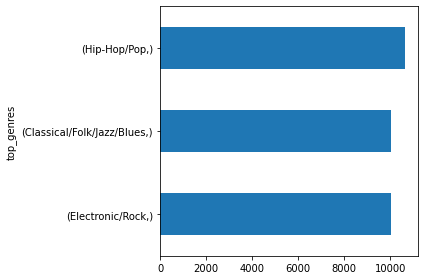

In [24]:
#Y Variable Distribution
i = 0
for var_name in ['top_genres']:
    tracks_reduced.select(var_name).toPandas().value_counts().sort_values().plot(kind = 'barh', color = 'C0')
plt.tight_layout()
plt.show()
display()

In [25]:
tracks_reduced.toPandas().to_csv('modelsampled.csv')

In [26]:
from pyspark.sql import SparkSession
from pyspark.sql import SQLContext
from pyspark.sql.functions import lower, col
MAX_MEMORY = "12g"
spark = SparkSession \
  .builder \
  .master("local[*]")\
  .config("spark.memory.fraction", 0.8) \
  .config("spark.executor.memory", MAX_MEMORY) \
  .config("spark.driver.memory", MAX_MEMORY)\
  .config("spark.memory.offHeap.enabled",'true')\
  .config("spark.memory.offHeap.size",MAX_MEMORY)\
  .getOrCreate()

sc = spark.sparkContext
sqlContext = SQLContext(sc)

In [27]:
genre_class_df =  tracks_reduced

In [28]:
genre_class_df.show()

+--------------------+-------------------+---------------------+---------------+--------+--------+--------------------+-----------+----------+-----------+----+----+-----------------+------------------+-----------------+----------------+-------+---+
|          top_genres|num_tracks_in_album|num_listens_per_album|track_favorites|duration|interest|num_listens_per_song|chroma_cens|chroma_cqt|chroma_stft|mfcc|rmse|spectral_centroid|spectral_bandwidth|spectral_contrast|spectral_rolloff|tonnetz|zcr|
+--------------------+-------------------+---------------------+---------------+--------+--------+--------------------+-----------+----------+-----------+----+----+-----------------+------------------+-----------------+----------------+-------+---+
|Classical/Folk/Ja...|                  3|                    4|              4|       0|       4|                   4|          2|         1|          0|   1|   0|                0|                 0|                0|               0|      2|  0|
|Cla

In [29]:
from pyspark.ml import feature, regression, evaluation, Pipeline
imp_cols=features

for col_name in imp_cols:
    genre_class_df = genre_class_df.withColumn(col_name, col(col_name).cast('float'))

feature_engineering_pipe = Pipeline(stages=[
  feature.StringIndexer(inputCol='top_genres', handleInvalid='skip',outputCol = "Y_top_genre")
]).fit(genre_class_df)

genreclass_df=feature_engineering_pipe.transform(genre_class_df)
columns_to_drop = ['top_genres']
feat=genreclass_df.columns
genreclass_df.select(feat).toPandas().to_csv('Final_Model_Dataset.csv')
genreclass_df = genreclass_df.drop(*columns_to_drop)

train_df,test_df = genreclass_df.randomSplit([0.7, 0.3], seed=0)


FEATURE SELECTION

In [30]:
import pandas as pd
import matplotlib.pyplot as plt
from pyspark.ml import feature, regression, evaluation, Pipeline
from pyspark.sql import functions as fn, Row 
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.classification import RandomForestClassifier
import matplotlib.pyplot as plt
from pyspark.mllib.evaluation import BinaryClassificationMetrics, MulticlassMetrics
from pyspark.ml.evaluation import BinaryClassificationEvaluator, MulticlassClassificationEvaluator
from pyspark.ml.tuning import ParamGridBuilder
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.feature import StandardScaler

VectorAssembler=VectorAssembler(inputCols= train_df.select(features).columns , outputCol = 'num_features')

RFBasemodel = RandomForestClassifier(labelCol="Y_top_genre", \
                            featuresCol="num_features")

top_genre_pipe = Pipeline(stages=[VectorAssembler, RFBasemodel]).fit(train_df)

evaluatorMulti = MulticlassClassificationEvaluator(labelCol="Y_top_genre", predictionCol="prediction")
evaluator = BinaryClassificationEvaluator(labelCol="Y_top_genre", rawPredictionCol="prediction", metricName='areaUnderROC')

predictionAndTarget = top_genre_pipe.transform(test_df).select("Y_top_genre", "prediction")

# Test BaseModel Evaluation
acc = evaluatorMulti.evaluate(predictionAndTarget, {evaluatorMulti.metricName: "accuracy"})
f1 = evaluatorMulti.evaluate(predictionAndTarget, {evaluatorMulti.metricName: "f1"})
weightedPrecision = evaluatorMulti.evaluate(predictionAndTarget, {evaluatorMulti.metricName: "weightedPrecision"})
weightedRecall = evaluatorMulti.evaluate(predictionAndTarget, {evaluatorMulti.metricName: "weightedRecall"})

print('************************Test Evaluation*************************')
print("Accuracy: %s\nf1: %s\nPrecision: %s\nRecall: %s"
      % (acc, f1, weightedPrecision, weightedRecall))

************************Test Evaluation*************************
Accuracy: 0.5575535695057607
f1: 0.5555484877951291
Precision: 0.5652708264411883
Recall: 0.5575535695057607


In [31]:
rf_model = top_genre_pipe.stages[-1]
a=pd.DataFrame(list(zip([cols for cols in genreclass_df.select(features).columns if cols != 'Y_top_genre'], rf_model.featureImportances.toArray())),
            columns = ['column', 'weight']).sort_values('weight',ascending = False)
a.column.values

array(['chroma_stft', 'spectral_rolloff', 'mfcc', 'spectral_centroid',
       'rmse', 'spectral_contrast', 'interest', 'num_listens_per_song',
       'track_favorites', 'zcr', 'duration', 'chroma_cens',
       'spectral_bandwidth', 'tonnetz', 'num_listens_per_album',
       'num_tracks_in_album', 'chroma_cqt'], dtype=object)

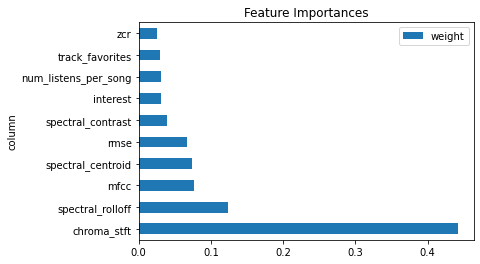

In [32]:
#plot graph of feature importances for better visualization
feat_importances = a.head(10).set_index('column').plot(kind='barh')
feat_importances
plt.title('Feature Importances')
plt.show()


Song recommender **systerm**

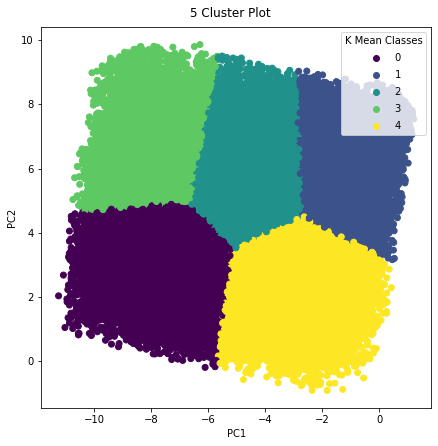

In [33]:
# your code here
feat.remove('top_genres')
feat.remove('Y_top_genre')
from pyspark.ml import clustering
from pyspark.ml import clustering
#VectorAssembler=VectorAssembler(inputCols= genreclass_df.select(feat).columns , outputCol = 'num_features')
pipe_pca4 = Pipeline(stages = [VectorAssembler,
                               feature.PCA(k=2, inputCol='num_features', outputCol='features')])
pipe_model4=pipe_pca4.fit(genreclass_df.select(feat))
chars_pca_df = pipe_model4.transform(genreclass_df.select(feat))
KMeans=clustering.KMeans(k = 5,predictionCol = 'Kmeans_feat')
Kmeans_pipe = Pipeline(stages = [KMeans])
Z_model = Kmeans_pipe.fit(chars_pca_df)
chars_pca_df= Z_model.transform(chars_pca_df) 
Z_pd = chars_pca_df.toPandas()
Z_pd.Kmeans_feat = Z_pd.Kmeans_feat.apply(lambda x:float(x))
X = np.array(chars_pca_df.select('features').rdd.map(lambda x: x['features']).collect())
fig, ax = plt.subplots()
fig.set_figheight(7)
fig.set_figwidth(7)
scatter = ax.scatter(X[:,0], X[:,1],c = Z_pd.Kmeans_feat)
fig.suptitle("5 Cluster Plot", y=.92)
ax.set_xlabel("PC1")
ax.set_ylabel("PC2")
legend1 = ax.legend(*scatter.legend_elements(),
                    loc="upper right", title="K Mean Classes")
plt.show()